In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os.path as osp
import struct
from datetime import datetime
from pylgmath import se3op

import matplotlib.pyplot as plt

from estimate_qc import *

## Get the SBET residuals

In [4]:
# root = '/workspace/raid/krb/boreas/boreas-2021-09-02-11-42/'
root = '/workspace/data1/boreas-2021-09-02-11-42/'
SBET_RATE = 200.0
skip = 20  # only use every skipth data from the SBET
dim = 6
C_enu_ned = np.array([[0, 1, 0],[1, 0, 0],[0, 0, -1]], dtype=np.float64)
DEG_TO_RAD = np.pi / 180
ARCSECOND_TO_DEG = 1.0 / 3600.0
changeovertime = 1627387200
# Periods during which daylight savings is in effect in Toronto
dst = [(1583650800, 1604210399), (1615705200, 1636264799), (1647154800, 1667714399), (1678604400, 1699163999), (1710054000, 1730613599)]
# Glen Shields LLA reference (first position of first sequence)
lla0 = np.array([0.7641426285531766, -1.3869452891985545, 153.67129211034626], dtype=np.float64)
R_w = np.diag([5.48885234e-06, 2.38789649e-05, 3.34471102e-06])
R_wa = (2 * R_w) * (SBET_RATE / skip)**2
R_a = np.diag([0.03792177, 0.01259208, 0.00849714])
R_aa_k = np.zeros((dim, dim))
R_aa_k[:3, :3] = R_a
R_aa_k[3:, 3:] = R_wa

## Convert North-East-Down-Roll-Pitch-Heading Covariance to T_vi Covariance

In [5]:
def wrapToPi(rads):
    if rads <= -np.pi:
        rads += 2 * np.pi
    if rads > np.pi:
        rads -= 2 * np.pi
    return rads

def get_T_v_i_covariance_from_nedrph_covariance(data, smr_data):
    
    lla = np.array([data[1], data[2], data[3]], dtype=np.float64)
    T_nedref_ned = RelLLAtoNED(lla, lla0)
    
    # what we get from sbet orientation (position of pos w.r.t. ned is zero)
    # note: pos frame is applanix frame here
    heading_wander = data[9]
    alpha = data[10]  # Wander angle
    
    heading_ned = heading_wander - alpha
    roll_ned = data[7]
    pitch_ned = data[8]

    def llarph_to_T_pos_enuref(h, p, r, delta_n = 0, delta_e = 0, delta_d = 0):
        T_ned_pos = np.eye(4, dtype=np.float64)
        # applanix uses different rotation conventions from our lab.
        T_ned_pos[:3, :3] = posOrientToRot(h, p, r)
        # what we need to compute is T_nedref_pos
        T_nedref_pos = np.matmul(T_nedref_ned, T_ned_pos)
        T_nedref_pos[0, 3] += delta_n
        T_nedref_pos[1, 3] += delta_e
        T_nedref_pos[2, 3] += delta_d
        # convert to ENU
        T_enu_ned = np.eye(4, dtype=np.float64)
        T_enu_ned[:3, :3] = C_enu_ned
        T_enuref_pos = np.matmul(T_enu_ned, T_nedref_pos)
        return get_inverse_tf(T_enuref_pos)

    Tbar = T_pos_enuref = llarph_to_T_pos_enuref(heading_ned, pitch_ned, roll_ned)

    
    n_rms = smr_data[1]
    e_rms = smr_data[2]
    d_rms = smr_data[3]
    roll_rms = smr_data[7] * ARCSECOND_TO_DEG * DEG_TO_RAD
    pitch_rms = smr_data[8] * ARCSECOND_TO_DEG * DEG_TO_RAD
    heading_rms = smr_data[9] * ARCSECOND_TO_DEG * DEG_TO_RAD

    samples = []
    samples.append(llarph_to_T_pos_enuref(heading_ned, pitch_ned, roll_ned, delta_n=n_rms))
    samples.append(llarph_to_T_pos_enuref(heading_ned, pitch_ned, roll_ned, delta_n=-n_rms))
    samples.append(llarph_to_T_pos_enuref(heading_ned, pitch_ned, roll_ned, delta_e=e_rms))
    samples.append(llarph_to_T_pos_enuref(heading_ned, pitch_ned, roll_ned, delta_e=-e_rms))
    samples.append(llarph_to_T_pos_enuref(heading_ned, pitch_ned, roll_ned, delta_d=d_rms))
    samples.append(llarph_to_T_pos_enuref(heading_ned, pitch_ned, roll_ned, delta_d=-d_rms))
    samples.append(llarph_to_T_pos_enuref(heading_ned, pitch_ned, wrapToPi(roll_ned + roll_rms)))
    samples.append(llarph_to_T_pos_enuref(heading_ned, pitch_ned, wrapToPi(roll_ned - roll_rms)))
    samples.append(llarph_to_T_pos_enuref(heading_ned, wrapToPi(pitch_ned + pitch_rms), roll_ned))
    samples.append(llarph_to_T_pos_enuref(heading_ned, wrapToPi(pitch_ned + pitch_rms), roll_ned))
    samples.append(llarph_to_T_pos_enuref(wrapToPi(heading_ned + heading_rms), pitch_ned, roll_ned))
    samples.append(llarph_to_T_pos_enuref(wrapToPi(heading_ned - heading_rms), pitch_ned, roll_ned))
    # Sigma_in = np.diag([n_cov, e])
    Sigma = np.zeros((6, 6))
    Tbar_inv = get_inverse_tf(Tbar)
    for T in samples:
        xi = se3op.tran2vec(T @ Tbar_inv).reshape(6, 1)
        Sigma += xi @ xi.transpose()
    Sigma *= 0.5
    # print('before: trans_norm {}'.format(npla.norm([n_rms, e_rms, d_rms])))
    # print('before: rot_norm {}'.format(npla.norm([roll_rms, pitch_rms, heading_rms])))
    # print('after: trans_norm {}'.format(npla.norm(np.sqrt(np.diag(Sigma)[:3]))))
    # print('after: rot_norm {}'.format(npla.norm(np.sqrt(np.diag(Sigma)[3:]))))
    return T_pos_enuref, Sigma

## Interface for interpolating SMR data at exactly the time that we want

In [6]:
with open(osp.join(root, 'applanix', 'smrmsg.out'), 'rb') as f:
    smr_fc = f.read()
smr_size = 10 * 8  # size of each line of smrmsg.out in bytes
smr_data_all = []
smr_data_times = []
for i in range(len(smr_fc) // smr_size):
    smr_data_all.append(struct.unpack("d" * 10, smr_fc[i * smr_size: (i + 1) * smr_size]))
    smr_data_times.append(smr_data_all[-1][0])

def get_smr_data_at_time(time, gps_times, gps_lines):
    idx = np.searchsorted(gps_times, time)
    if idx >= len(gps_times):
        idx = len(gps_times) - 1
    d = abs(gps_times[idx] - time)
    if gps_times[idx] < time and idx < len(gps_times) - 1:
        if abs(gps_times[idx + 1] - time) < d:
            idx += 1
    elif gps_times[idx] > time and idx > 0:
        if abs(gps_times[idx - 1] - time) < d:
            idx -= 1

    closest = idx
    gt_time = gps_times[closest]

    def _interpolate(lower, upper, t):
        assert(len(lower) == len(upper))
        tlow = lower[0]
        tupp = upper[0]
        assert(tlow < t and t < tupp)
        delta = tupp - tlow
        if delta == 0:
            return lower
        ratio = (t - tlow) / delta
        out = []
        for low, upp in zip(lower, upper):
            out.append(low + (upp - low) * ratio)
        out[0] = t
        return out

    line = gps_lines[closest]
    if gt_time < time:
        if closest == len(gps_lines) - 1:
            return line
        line_lower = line
        line_upper = gps_lines[closest + 1]
        return _interpolate(line_lower, line_upper, time)
    elif gt_time > time:
        if closest == 0:
            return line
        line_lower = gps_lines[closest - 1]
        line_upper = line
        return _interpolate(line_lower, line_upper, time)
    elif gt_time == time:
        return line
    

## Extract Pose and Covariances from SBET and SMRMSG

In [7]:
with open(osp.join(root, 'applanix', 'sbet.out'), 'rb') as f:
    sbet_fc = f.read()
with open(osp.join(root, 'applanix', 'ros_and_gps_time.csv')) as f:
    lines = f.readlines()
    start_time = float(lines[1].split(',')[1]) - 20
    end_time = float(lines[-1].split(',')[1]) + 20
print('start_time_gps: {}'.format(start_time))
print('end_time_gps: {}'.format(end_time))
dt = datetime.fromtimestamp(start_time)
weekday = dt.isoweekday()
if weekday == 7:
    weekday = 0
g2 = weekday * 24 * 3600 + dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond * 1e-6
start_week = round(start_time - g2)
gpstime0 = struct.unpack("d", sbet_fc[:8])[0]
print('gpstime0: {}'.format(gpstime0))
# get timezone offset:
# Toronto time is GMT-4 or GMT-5 depending on time of year
time_zone_offset = 5 * 3600
for period in dst:
    if period[0] < start_time and start_time < period[1]:
        time_zone_offset = 4 * 3600

time_zone_offset = 0

if 'boreas-2021-01-19-15-08' in root:
    time_zone_offset = 4 * 3600  # hardcode timezone offset for this sequence only

print('START WEEK: {} TIME ZONE OFFSET: {}'.format(start_week, time_zone_offset))
start_gps = start_time + time_zone_offset - start_week
end_gps = end_time + time_zone_offset - start_week
if start_time > changeovertime:
    start_gps += 18  # UTC --> GPS
    end_gps += 18
print('start_gps: {} end_gps: {}'.format(start_gps, end_gps))

sbet_size = 17 * 8
# smr_size = 10 * 8  # size of each line of smrmsg.out in bytes

sbet_times = []
sbet_data_all = []

poses = []
pos_covs = []
ang_vels = []
vels = []
vel_covs = []
accels = []
ang_accels = []

w_prev = np.zeros((3, 1))

for i in list(range(len(sbet_fc) // sbet_size))[::skip]:
    # SBET Data:
    data = struct.unpack("d" * 17, sbet_fc[i * sbet_size: (i + 1) * sbet_size])
    if data[0] < start_gps or data[0] > end_gps:
        continue
    sbet_times.append(data[0])
    sbet_data_all.append(data)
    # convert lat, lng to Easting, Northing in UTM
    latitude = data[1]
    longitude = data[2]
    lla = np.array([data[1], data[2], data[3]], dtype=np.float64)
    T_nedref_ned = RelLLAtoNED(lla, lla0)

    # what we get from sbet orientation (position of pos w.r.t. ned is zero)
    # note: pos frame is applanix frame here
    # heading_wander = data[9]
    alpha = data[10]  # Wander angle
    # heading_ned = heading_wander - alpha
    # roll_ned = data[7]
    # pitch_ned = data[8]

    smr_data = get_smr_data_at_time(data[0], smr_data_times, smr_data_all)
    T_pos_enuref, Sigma = get_T_v_i_covariance_from_nedrph_covariance(data, smr_data)
    T_enuref_pos = get_inverse_tf(T_pos_enuref)

    v_x = data[4]
    v_y = data[5]
    v_n = v_x * np.cos(alpha) - v_y * np.sin(alpha)   # Velocity in north direction
    v_e = -v_x * np.sin(alpha) - v_y * np.cos(alpha)  # Velocity in east direction
    
    # rotate velocity from local ned to reference ned
    v_nedref = np.matmul(T_nedref_ned[:3, :3], np.array([v_n, v_e, -data[6]], np.float64))
    v_e = v_nedref[1]
    v_n = v_nedref[0]
    v_up = -v_nedref[2]

    v = T_pos_enuref[:3, :3] @ np.array([v_e, v_n, v_up]).reshape(3, 1)
    a = np.array([data[11], data[12], data[13]]).reshape(3, 1)
    w = np.array([data[14], data[15], data[16]]).reshape(3, 1)
    wa = (w - w_prev) * SBET_RATE / skip  # finite difference approximation

    v_rms = np.array([smr_data[5], smr_data[4], smr_data[6]]).reshape(3, 1)
    v_cov = np.diag(v_rms.squeeze()**2)
    C = T_pos_enuref[:3, :3]
    v_cov = C @ v_cov @ C.T

    poses.append(T_pos_enuref)
    pos_covs.append(Sigma)
    vels.append(v.squeeze())
    ang_vels.append(w.squeeze())
    accels.append(a.squeeze())
    vel_covs.append(v_cov)
    ang_accels.append(wa.squeeze())
    w_prev = np.copy(w)

start_time_gps: 1630597311.036218
end_time_gps: 1630598384.6390462
gpstime0: 401729.0551340226
START WEEK: 1630195200 TIME ZONE OFFSET: 0
start_gps: 402129.03621792793 end_gps: 403202.63904619217


In [8]:
poses = np.expand_dims(np.array(poses), axis=0)
pos_covs = np.expand_dims(np.array(pos_covs), axis=0)
accels = np.expand_dims(np.array(accels), axis=0)
vels = np.expand_dims(np.array(vels), axis=0)
ang_vels = np.expand_dims(np.array(ang_vels), axis=0)
vel_covs = np.expand_dims(np.array(vel_covs), axis=0)
ang_accels = np.expand_dims(np.array(ang_accels), axis=0)

In [9]:
with open(osp.join(root, 'applanix', 'imu_raw.csv'), 'r') as f:
    h = f.readline()
    imu_raw_lines = f.readlines()

imu_lines = []
for line in imu_raw_lines:
    line = [float(x) for x in line.rstrip().split(',')]
    imu_lines.append(line)

imu_data_raw = np.array(imu_lines)
imu_data_raw_times = imu_data_raw[::skip, 0]
imu_data_raw = imu_data_raw[::skip, 1:]
assert imu_data_raw.shape[0] == poses.shape[1]
imu_raw = np.copy(imu_data_raw)

## Compute the local variables at each timestep

In [10]:
imu_body_raw_to_applanix = np.array([0, -1, 0, -1, 0, 0, 0, 0, -1]).reshape(3, 3)
dim = 6
gamma1 = []
gamma2 = []
biases = []
t = 0
for i in range(poses.shape[1]):
    if i < poses.shape[1] - 1:
        g1 = np.zeros((dim * 3, 1))
        g2 = np.zeros((dim * 3, 1))
        g1[6 : 9] = vels[t, i].reshape(3, 1)
        g1[9 : 12] = ang_vels[t, i].reshape(3, 1)
        g1[12 : 15] = accels[t, i].reshape(3, 1)
        g1[15 : 18] = ang_accels[t, i].reshape(3, 1)
        xi_21 = se3op.tran2vec(poses[t, i + 1] @ get_inverse_tf(poses[t, i]))
        g2[:6] = xi_21
        J_21_inv = se3op.vec2jacinv(xi_21)
        w2 = np.array([vels[t, i + 1], ang_vels[t, i + 1]]).reshape(6, 1)
        temp = J_21_inv @ w2
        g2[6 : 12] = temp
        dw2 = np.array([accels[t, i + 1], ang_accels[t, i + 1]]).reshape(6, 1)
        g2[12 : 18] = -0.5 * se3op.curlyhat(temp) @ w2 + J_21_inv @ dw2
        gamma1.append(g1)
        gamma2.append(g2)
        
        C_vi = poses[0, i, :3, :3]
        a_raw = imu_body_raw_to_applanix @ imu_raw[i, [5,4,3]].reshape(3, 1)
        a = accels[0, i + 1].reshape(3, 1)
        biases.append(a_raw - a + C_vi @ np.array([0, 0, -9.8042]).reshape(3, 1))
gamma1 = np.expand_dims(np.array(gamma1), axis=0)
gamma2 = np.expand_dims(np.array(gamma2), axis=0)
biases = np.expand_dims(np.array(biases), axis=0)

## Estimate Gravity Vector Magnitude at t=0

In [11]:
s = np.zeros((3, 1))
d = np.array([0, 0, 1]).reshape(1, 3)

N = 25

# clue: SBET

for i in range(1, N):
    C_vi = poses[0, i, :3, :3]
    a_raw = imu_body_raw_to_applanix @ imu_raw[i, [5,4,3]].reshape(3, 1)
    # print('a_raw: {} |a_raw|: {}'.format(a_raw.squeeze(), npla.norm(a_raw)))
    a = accels[0, i].reshape(3, 1)
    # print('a: {} |a|: {}'.format(a.squeeze(), npla.norm(a)))
    # print(npla.norm(a - a_raw))
    s += C_vi.T @ (a - a_raw)
    # break

print('SBET:')
print(a)
print('Raw - C_vi g:')
print(a_raw + C_vi @ np.array([0, 0, -9.8042]).reshape(3, 1))
print('Raw:')
print(a_raw)

g = s / N
print('g: {}'.format(g))
print('|g|: {}'.format(npla.norm(g)))

SBET:
[[-0.09631976]
 [-0.01690749]
 [ 0.02744254]]
Raw - C_vi g:
[[ 0.14826396]
 [ 0.04077862]
 [-0.03057443]]
Raw:
[[-5.508000e-03]
 [ 3.425400e-01]
 [ 9.767774e+00]]
g: [[ 1.39593453e-02]
 [ 3.28093508e-03]
 [-9.39724484e+00]]
|g|: 9.39725578320358


## Estimate Bias Kinematics (Accelerometer)

In [12]:
from pylgmath import so3op
s = np.zeros((3, 1))
dt = 1.0 / (SBET_RATE / skip)
qb = np.array([1.0, 1.0, 1.0])
qa = np.array([3.78207917, 3.78207917, 3.78207917])
# Numerical Results
qc_diag = np.array([7.446e+04, 7.446e+04,  2.699e+03,  7.155e+01,  1.183e+01,  6.578e-01])
ad_diag = np.array([4.909e+00, 7.293e+00,  9.998e+00,  8.210e+00,  1.670e+00,  5.980e+00])
# Analytical Results (without measurement noise)
# qc_diag = np.array([6.18108869e+04, 7.71192323e+07, 3.45732462e+03, 7.34543263e+02, 7.13707405e+02, 9.90013180e+03])
# ad_diag = np.array([3.85528515, 3.84949172, 3.88049649, 4.01160905, 4.01343317, 3.84995573])

Qk = get_q_singer(dt, ad_diag, qc_diag)
Q33 = Qk[-6:, -6:]
Qaa = Q33[:3, :3]
Qtt = Qk[3:6, 3:6]
print(Qaa)
Qa_2Ra = np.diag([0.00111481, 0.00385788, 0.00064409])
print(Qa_2Ra)

g = np.array([0, 0, -9.8042]).reshape(3, 1)

cost_prev = 0
cost_init = False

qb_prev = 0

dQ_dq = np.zeros((3, 3, 3))
dQ_dq[0, 0, 0] = 1
dQ_dq[1, 1, 1] = 1
dQ_dq[2, 2, 2] = 1

N = 250

for it in range(1000):
    dJ_dq = np.zeros(3)
    # Qk = np.diag(qa) + np.diag(qb)
    # Qk = Qaa + np.diag(qb)
    
    Qk_inv = npla.inv(Qk)
    cost = 0
    bas = []
    for i in range(N):
        C_k = poses[0, i, :3, :3]
        C_kp1 = poses[0, i + 1, :3, :3]
        # Qk = Qaa + R_a + R_a - so3op.hat(C_k @ g) @ Qtt @ so3op.hat(C_k @ g) - so3op.hat(C_kp1 @ g) @ Qtt @ so3op.hat(C_kp1 @ g) + np.diag(qb) * dt
        # Qk = np.diag(qb.squeeze()) * dt
        Rtt = pos_covs[0, i, -3:, -3:]
        Rtt2 = pos_covs[0, i + 1, -3:, -3:]
        Qk = Qa_2Ra - so3op.hat(C_k @ g) @ Rtt @ so3op.hat(C_k @ g) - so3op.hat(C_kp1 @ g) @ Rtt2 @ so3op.hat(C_kp1 @ g) + np.diag(qb) * dt
        Qk_inv = npla.inv(Qk)
        C_vi = poses[0, i, :3, :3]
        a_raw = imu_body_raw_to_applanix @ imu_raw[i, [5,4,3]].reshape(3, 1)
        a = accels[0, i].reshape(3, 1)
        # b = a_raw - a + C_vi @ np.array([0, 0, -9.8042]).reshape(3, 1)
        b = a_raw + C_vi @ np.array([0, 0, -9.8042]).reshape(3, 1)
        bas.append(b)
        if i > 0:
            e = b - b_prev
            for j in range(3):
                dJ_dq[j] += -0.5 * e.T @ Qk_inv @ dQ_dq[j] @ Qk_inv @ e * dt
            cost += 0.5 * e.T @ Qk_inv @ e + 0.5 * np.log(npla.det(Qk))
            e = a_raw - a_raw_prev
            for j in range(3):
                # print((e.T @ dQ_dq[j] @ e).shape)
                s[j, 0] += e.T @ dQ_dq[j] @ e
        b_prev = np.copy(b)
        a_prev = np.copy(a)
        a_raw_prev = np.copy(a_raw)
    dJ_dq /= (imu_raw.shape[0] - 1)
    for j in range(3):
        dJ_dq[j] += 0.5 * np.trace(Qk_inv @ dQ_dq[j] * dt)
    
    print('cost: {} dJ_dqb: {} qb: {}'.format(cost.item(), dJ_dq.squeeze(), qb.squeeze()))

    if cost.item() - cost_prev > 0 and cost_init is True:
        print("Min cost reached")
        break

    qb = qb - dJ_dq

    if np.linalg.norm(qb - qb_prev) < 1.0e-3:
        print("Parameters converged!")
        break

    qb_prev = np.copy(qb)
    cost_prev = cost.item()
    cost_init = True
    # break

# qc = (1 / imu_raw.shape[0]) * s
# print('qa_2Ra: {}'.format(qc.squeeze()))

[[4742.77780919    0.            0.        ]
 [   0.         3917.69236192    0.        ]
 [   0.            0.          116.70253717]]
[[0.00111481 0.         0.        ]
 [0.         0.00385788 0.        ]
 [0.         0.         0.00064409]]
cost: -560.720107139032 dJ_dqb: [0.48904505 0.46358033 0.49362064] qb: [1. 1. 1.]
cost: -551.7446853369734 dJ_dqb: [0.93725249 0.81134307 0.96275411] qb: [0.51095495 0.53641967 0.50637936]
Min cost reached


In [13]:
print(accels.shape)
print(imu_raw.shape)

(1, 10736, 3)
(10736, 6)


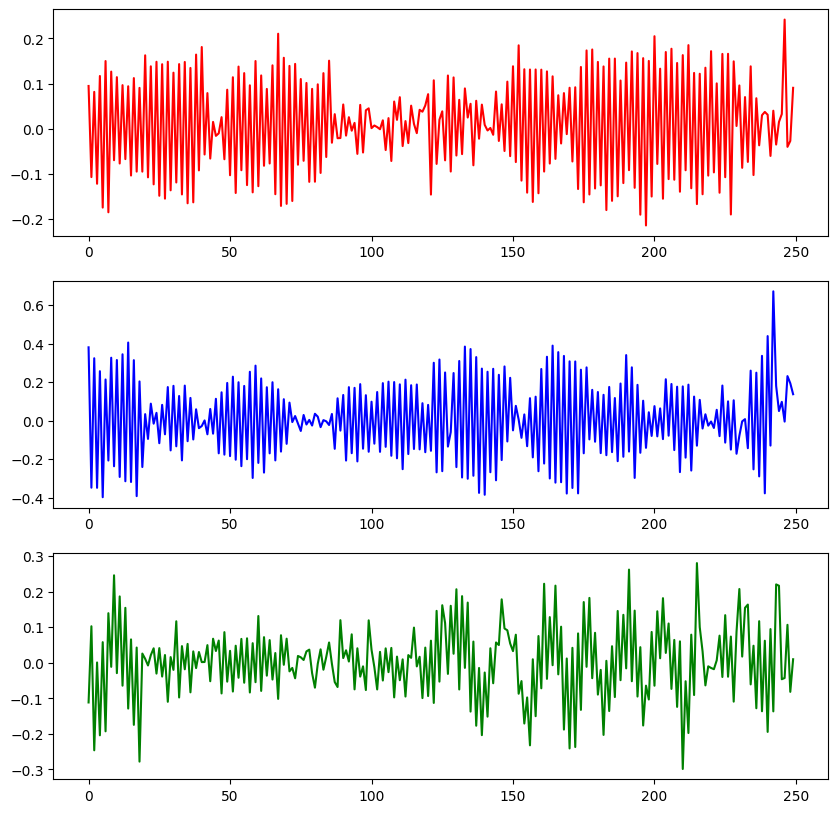

In [14]:
N = 250
bas = np.array(bas)
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(bas[:N, 0], 'r')
axs[1].plot(bas[:N, 1], 'b')
axs[2].plot(bas[:N, 2], 'g')


x = imu_raw[:N, [5, 4, 3]] @ imu_body_raw_to_applanix.T
# axs[0].plot(accels[0, :N, 0], 'r')
# axs[0].plot(x[:, 0], 'b')
# axs[1].plot(accels[0, :N, 1], 'r')
# axs[1].plot(x[:, 1], 'b')
# axs[2].plot(accels[0, :N, 2], 'r')
# axs[2].plot(x[:, 2], 'b')
# axs[0].plot(biases[0, :N, 0], 'r')
# axs[1].plot(biases[0, :N, 1], 'r')
# axs[2].plot(biases[0, :N, 2], 'r')

plt.show()

In [15]:
from pylgmath import so3op
s = np.zeros((3, 1))
dt = 1.0 / (SBET_RATE / skip)
qb = np.array([2.4654288279,   3.9767341354, 120.9893929939])
# Numerical Results
# qc_diag = np.array([7.446e+04, 7.446e+04,  2.699e+03,  7.155e+01,  1.183e+01,  6.578e-01])
# ad_diag = np.array([4.909e+00, 7.293e+00,  9.998e+00,  8.210e+00,  1.670e+00,  5.980e+00])
# Analytical Results (without measurement noise)
# qc_diag = np.array([6.18108869e+04, 7.71192323e+07, 3.45732462e+03, 7.34543263e+02, 7.13707405e+02, 9.90013180e+03])
# ad_diag = np.array([3.85528515, 3.84949172, 3.88049649, 4.01160905, 4.01343317, 3.84995573])

# Qk = get_q_singer(dt, ad_diag, qc_diag)
# Q33 = Qk[-6:, -6:]
# Qaa = Q33[:3, :3]
# Qtt = Qk[3:6, 3:6]
# print(Qaa)
Qw_2Rw = np.diag([1.87328911e-03, 1.97666629e-03, 7.45131462e-05])
print(Qw_2Rw)

cost_init = False

qb_prev = 0

dQ_dq = np.zeros((3, 3, 3))
dQ_dq[0, 0, 0] = 1
dQ_dq[1, 1, 1] = 1
dQ_dq[2, 2, 2] = 1
for it in range(1000):
    dJ_dq = np.zeros(3)
    cost = 0
    bs = []
    for i in range(gamma1.shape[1]):
        Qk = Qw_2Rw + np.diag(qb) * dt
        Qk_inv = npla.inv(Qk)
        w_raw = imu_body_raw_to_applanix @ imu_raw[i, [2,1,0]].reshape(3, 1)
        w = ang_vels[0, i].reshape(3, 1)
        b = w_raw - w
        bs.append(np.copy(b))
        if i > 0:
            e = b - b_prev
            for j in range(3):
                dJ_dq[j] += -0.5 * e.T @ Qk_inv @ dQ_dq[j] @ Qk_inv @ e * dt
            cost += 0.5 * e.T @ Qk_inv @ e + 0.5 * np.log(npla.det(Qk))
            e = w - w_prev
            for j in range(3):
                s[j, 0] += e.T @ dQ_dq[j] @ e
        b_prev = np.copy(b)
        w_prev = np.copy(w)
    dJ_dq /= (gamma1.shape[1] - 1)
    for j in range(3):
        dJ_dq[j] += 0.5 * np.trace(Qk_inv @ dQ_dq[j] * dt)
    
    print('cost: {} dJ_dqb: {} qb: {}'.format(cost.item(), dJ_dq.squeeze(), qb.squeeze()))

    if cost.item() - cost_prev > 0 and cost_init is True:
        print("Min cost reached")
        break

    qb = qb - dJ_dq

    if np.linalg.norm(qb - qb_prev) < 1.0e-3:
        print("Parameters converged!")
        break

    qb_prev = np.copy(qb)
    cost_prev = cost.item()
    cost_init = True
    print(np.std(bs, axis=0))
    break

# qc = (1 / gamma1.shape[1]) * s
# print('qw_2Rw: {}'.format(qc.squeeze()))

[[1.87328911e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97666629e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.45131462e-05]]
cost: 1043.937994569593 dJ_dqb: [0.19964808 0.12471971 0.00413255] qb: [  2.46542883   3.97673414 120.98939299]
[[0.02587405]
 [0.03145004]
 [0.0045737 ]]


## Train GP Prior using hand-derived gradients

In [41]:
import scipy.linalg as spla
import scipy.sparse as sp_sparse
from sksparse.cholmod import cholesky
from time import time

# qc = np.array([6.18728937e+04, 7.71192324e+07, 4.17524192e+03, 9.25826720e+01, 9.61858481e+04, 9.84386783e+03])
# ad = np.array([ 44.31224566,  47.04259191,  55.16873919, 115.64409274, 150.0933861, 141.08361487])

# qc = np.array([  6313.91127535, 240840.24631095,   1987.75252132,   1021.24977399, 984.00500256,   3321.85613123])
# ad = np.array([ 4.10837245,  0.19507133, 29.74753024, 50.56987599, 51.35344379, 17.68425378])

qc = np.array([2.38403321e+05, 2.97720003e+08, 1.74397974e+04, 3.18132867e+03, 3.01068675e+03, 3.82057567e+04])
ad = np.array([107.11562617, 114.95408465, 129.56299218, 125.8981169,  125.70556379, 114.78771678])


dim = 6
# qc = np.ones(dim)  # ** use this to train from scratch
# ad = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])  # ** use this to train from scratch
dt = 1.0 / (SBET_RATE / skip)
lr_ad = 1.0e+5  # ** set to 1.0e+0 to train from scratch
lr_qc = 1.0e+6  # ** set to 1.0e+0 to train from scratch

# lr schedule: 1.0 for about 20 iterations, then 10.0 for qc for a long time

params = []
cost = []
lrs = []

N = 10000

K = gamma1.shape[1]
# K = 1000

ad_prev = ad
qc_prev = qc
cost_prev = 0
cost_init = False

D = dim * 3
Q = sp_sparse.lil_array((K * D, K * D))
e = np.zeros((K * D, 1))

dQ_da = []
dQ_dqc = []
de_da = []
for j in range(dim):
    dQ_da.append(sp_sparse.lil_array((K * D, K * D)))
    dQ_dqc.append(sp_sparse.lil_array((K * D, K * D)))
    de_da.append(np.zeros((K * D, 1)))

for it in range(N):
    start = time()
    params.append([qc, ad])


    Phi = get_tran_singer(dt, ad)
    C1 = Phi[:dim, -dim:]
    C2 = Phi[dim : 2 * dim, -dim:]
    C3 = Phi[-dim:, -dim:]
    
    Qk = get_q_singer(dt, ad, qc)
    Q_alpha_dt = get_q_singer(dt, ad, np.ones(6))

    for i in range(K):
        e[i * D : (i + 1) * D] = gamma2[t, i] - Phi @ gamma1[t, i]
        
        R_vv_k = np.zeros((dim, dim))
        R_vv_k[:3, :3] = vel_covs[t, i]
        R_vv_k[3:, 3:] = R_w

        R_vv_k2 = np.zeros((dim, dim))
        R_vv_k2[:3, :3] = vel_covs[t, i + 1]
        R_vv_k2[3:, 3:] = R_w

        R_k = np.zeros((D, D))
        R_k[:dim, :dim] = pos_covs[t, i]
        R_k[dim:2*dim, dim:2*dim] = R_vv_k
        R_k[-dim:, -dim:] = R_aa_k

        R_k2 = np.zeros((D, D))
        R_k2[:dim, :dim] = pos_covs[t, i + 1]
        R_k2[dim:2*dim, dim:2*dim] = R_vv_k2
        R_k2[-dim:, -dim:] = R_aa_k
        
        Q[i * D : (i + 1) * D, i * D : (i + 1) * D] = R_k2 + Phi @ R_k @ Phi.T + Qk
        
        if i < K - 1:
            cov_12 = -R_k2 @ Phi.T
            Q[(i + 1) * D : (i + 2) * D, i * D : (i + 1) * D] = cov_12.T
            Q[i * D : (i + 1) * D, (i + 1) * D : (i + 2) * D] = cov_12

        dQk_dqc = get_jac_Q_sigma(qc) @ Q_alpha_dt
        # # Note: be careful, if ad < 0.05, dQk_da for that dim is set to zero...
        dQk_da = get_jac_Qk_alpha(dt, ad, qc)
        dek_da = get_jac_ek_alpha(dt, ad, gamma1[t, i].reshape(-1, 1))

        for j in range(dim):
            dQ_dqc[j][i * D : (i + 1) * D, i * D : (i + 1) * D] = dQk_dqc[j]
            de_da[j][i * D : (i + 1) * D] = dek_da[j]
        
        dC_da = get_jac_C_alpha(dt, ad)

        dcov_kk_da = np.zeros((D, D))
        for j in range(dim):
            dC1_da = dC_da[j, :dim, :dim]
            dC2_da = dC_da[j, dim : 2 * dim, :dim]
            dC3_da = dC_da[j, -dim:, :dim]
            dcov_kk_da[:dim, :dim] = C1 @ R_aa_k @ dC1_da.T + dC1_da @ R_aa_k @ C1.T
            dcov_kk_da[:dim, dim : 2 * dim] = C1 @ R_aa_k @ dC2_da.T + dC1_da @ R_aa_k @ C2.T
            dcov_kk_da[dim : 2 * dim, :dim] = dcov_kk_da[:dim, dim : 2 * dim].T
            dcov_kk_da[:dim, 2 * dim : 3 * dim] =  C1 @ R_aa_k @ dC3_da.T + dC1_da @ R_aa_k @ C3.T
            dcov_kk_da[2 * dim : 3 * dim, :dim] = dcov_kk_da[:dim, 2 * dim : 3 * dim].T
            dcov_kk_da[dim : 2 * dim, dim : 2 * dim] = C2 @ R_aa_k @ dC2_da.T + C2.T @ R_aa_k @ dC2_da
            dcov_kk_da[dim : 2 * dim, 2 * dim : 3 * dim] = C2 @ R_aa_k @ dC3_da.T + dC2_da @ R_aa_k @ C3.T
            dcov_kk_da[2 * dim : 3 * dim, dim : 2 * dim] = dcov_kk_da[dim : 2 * dim, 2 * dim : 3 * dim].T
            dcov_kk_da[-dim:, -dim:] = C3 @ R_aa_k @ dC3_da.T + dC3_da @ R_aa_k @ C3.T
            dQ_da[j][i * D : (i + 1) * D, i * D : (i + 1) * D] = dcov_kk_da + dQk_da[j]

        if i < K - 1:    
            for j in range(dim):
                dcov_12_da = np.zeros((D, D))
                dC1_da = dC_da[j, :dim, :dim]
                dC2_da = dC_da[j, dim : 2 * dim, :dim]
                dC3_da = dC_da[j, -dim:, :dim]
                dcov_12_da[-dim:, :dim] = -R_aa_k @ dC1_da.T
                dcov_12_da[-dim:, dim : 2*dim] = -R_aa_k @ dC2_da.T
                dcov_12_da[-dim:, -dim:] = -R_aa_k @ dC3_da.T
                dQ_da[j][(i + 1) * D : (i + 2) * D, i * D : (i + 1) * D] = dcov_12_da.T
                dQ_da[j][i * D : (i + 1) * D, (i + 1) * D : (i + 2) * D] = dcov_12_da

    
    factor = cholesky(Q.tocsc(), beta=0, mode="simplicial", ordering_method="natural")
    dJ_dqc = np.zeros(dim)
    dJ_da = np.zeros(dim)
    Q_inv_e = factor(e)

    Q_inv, L = get_blk_tridiag_inv_from_blk_tridiag(Q)

    for j in range(dim):
        dJ_dqc[j] = -0.5 * Q_inv_e.T @ dQ_dqc[j] @ Q_inv_e + 0.5 * compute_trace_of_blktridiag_Ainv_B_v2(Q_inv, dQ_dqc[j])
        dJ_da[j] = -0.5 * Q_inv_e.T @ dQ_da[j] @ Q_inv_e + Q_inv_e.T @ de_da[j] + 0.5 * compute_trace_of_blktridiag_Ainv_B_v2(Q_inv, dQ_da[j])

    # cost = 0.5 * e.T @ Q_inv_e + 0.5 * logdet_blk_tridiag1(Q)
    cost = 0.5 * e.T @ Q_inv_e + 0.5 * logdet_blk_tridiag3(L)

    dJ_dqc /= K
    dJ_da /= K

    print("cost: {} qc: {} ad: {} dJ_dqc: {} dJ_da: {} time: {}".format(cost.item(), qc.squeeze(), ad.squeeze(), dJ_dqc.squeeze(), dJ_da.squeeze(), (time() - start)))

    qc = qc - lr_qc * dJ_dqc
    if it > 0:
        ad = ad - lr_ad * dJ_da
        # for j in range(ad.shape[0]):
        #     if j != 1:
        #         ad[j] = ad[j] - lr_ad * dJ_da[j]
        #     else:
        #         ad[j] = ad[j] - 1.0 * dJ_da[j]
    for j in range(ad.shape[0]):
        if ad[j] < 0.05:
            ad[j] = 0.0
            dJ_da[j] = 0.0

    for j in range(qc.shape[0]):
        if qc[j] < 0:
            qc[j] = 1.0e-1

    # if it > 20:
    #     lr_qc = 10.0

    if np.linalg.norm(ad - ad_prev) < 1.0e-3 and np.linalg.norm(qc - qc_prev) < 1.0e-3:
        print("Parameters converged!")
        break

    if cost.item() - cost_prev > 0 and cost_init is True:
        print("Min cost reached")
        break

    ad_prev = np.copy(ad)
    qc_prev = np.copy(qc)
    cost_prev = cost.item()
    cost_init = True

cost: 15917.120256455819 qc: [2.38403321e+05 2.97720003e+08 1.74397974e+04 3.18132867e+03
 3.01068675e+03 3.82057567e+04] ad: [107.11562617 114.95408465 129.56299218 125.8981169  125.70556379
 114.78771678] dJ_dqc: [-9.61668742e-08  1.76442526e-12  2.49672809e-06  4.74323451e-06
  4.99785472e-06  1.09947032e-07] dJ_da: [-2.63020985e-08  5.25485002e-05  1.05467391e-05  1.18432255e-04
  1.31751740e-04  2.01011174e-07] time: 85.02825856208801
cost: 15916.581886719112 qc: [2.38403417e+05 2.97720003e+08 1.74373007e+04 3.17658544e+03
 3.00568890e+03 3.82056468e+04] ad: [107.11562617 114.95408465 129.56299218 125.8981169  125.70556379
 114.78771678] dJ_dqc: [-9.61644043e-08  1.76442510e-12  2.48875485e-06  4.05845583e-06
  4.21724743e-06  1.09834735e-07] dJ_da: [-3.36313754e-08  5.25485007e-05  1.22001530e-05  1.43694887e-04
  1.59055407e-04  2.53503921e-07] time: 88.78662347793579
cost: 16461.072194878798 qc: [2.38403513e+05 2.97720003e+08 1.74348119e+04 3.17252698e+03
 3.00147165e+03 3.8205

In [23]:
print("cost: {} qc: {} ad: {} dJ_dqc: {} dJ_da: {} time: {}".format(cost.item(), qc.squeeze(), ad.squeeze(), dJ_dqc.squeeze(), dJ_da.squeeze(), (time() - start)))

cost: 5678212.222191297 qc: [  1996.96409173 238995.15796686    638.73929984    409.01018776
    390.26699083   1486.57905406] ad: [ 1.7701856   0.19406699 15.36469625 29.16675812 30.02959443  9.65855218] dJ_dqc: [-232.03341725  -21.59835424  -76.20718207    0.            0.
    0.        ] dJ_da: [-1.62398265e+00 -1.84466378e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00] time: 61.4421112537384


In [ ]:
## Check Jacobians...

K = 1000

Q = sp_sparse.lil_array((K * D, K * D))
e = np.zeros((K * D, 1))

dQ_da = []
dQ_dqc = []
de_da = []
for j in range(dim):
    dQ_da.append(sp_sparse.lil_array((K * D, K * D)))
    dQ_dqc.append(sp_sparse.lil_array((K * D, K * D)))
    de_da.append(np.zeros((K * D, 1)))

eps = 1.0e-5

Js = []
params = []

qc = np.array([6.18728878e+04, 7.71192324e+07, 4.17519925e+03, 9.22570398e+01, 9.61858530e+04, 9.84390485e+03])
ad = np.array([100.0,   100.0,  100.0, 100.11210557, 100.06214632, 100.15317244])

for dd in range(dim):
    xi = np.zeros(dim)
    xi[dd] = eps
    params.append((ad + xi, qc))
    params.append((ad - xi, qc))

for dd in range(dim):
    xi = np.zeros(dim)
    xi[dd] = eps
    params.append((ad, qc + xi))
    params.append((ad, qc - xi))

for ad,qc in params:

    Phi = get_tran_singer(dt, ad)
    C1 = Phi[:dim, -dim:]
    C2 = Phi[dim : 2 * dim, -dim:]
    C3 = Phi[-dim:, -dim:]
    
    Qk = get_q_singer(dt, ad, qc)
    Q_alpha_dt = get_q_singer(dt, ad, np.ones(6))
    
    for i in range(K):
        e[i * D : (i + 1) * D] = gamma2[t, i] - Phi @ gamma1[t, i]
        
        R_vv_k = np.eye(dim)
        # R_vv_k = np.zeros((dim, dim))
        # R_vv_k[:3, :3] = vel_covs[t, i]
        # R_vv_k[3:, 3:] = R_w
    
        R_vv_k2 = np.eye(dim)
        # R_vv_k2 = np.zeros((dim, dim))
        # R_vv_k2[:3, :3] = vel_covs[t, i + 1]
        # R_vv_k2[3:, 3:] = R_w
    
        R_k = np.eye(D)
        # R_k = np.zeros((D, D))
        # R_k[:dim, :dim] = pos_covs[t, i]
        # R_k[dim:2*dim, dim:2*dim] = R_vv_k
        # R_k[-dim:, -dim:] = R_aa_k
    
        R_k2 = np.eye(D)
        # R_k2 = np.zeros((D, D))
        # R_k2[:dim, :dim] = pos_covs[t, i + 1]
        # R_k2[dim:2*dim, dim:2*dim] = R_vv_k2
        # R_k2[-dim:, -dim:] = R_aa_k
        
        Q[i * D : (i + 1) * D, i * D : (i + 1) * D] = R_k2 + Phi @ R_k @ Phi.T + Qk
        
        if i < K - 1:
            cov_12 = -R_k2 @ Phi.T
            Q[(i + 1) * D : (i + 2) * D, i * D : (i + 1) * D] = cov_12.T
            Q[i * D : (i + 1) * D, (i + 1) * D : (i + 2) * D] = cov_12
    
        dQk_dqc = get_jac_Q_sigma(qc) @ Q_alpha_dt
        # # Note: be careful, if ad < 0.05, dQk_da for that dim is set to zero...
        dQk_da = get_jac_Qk_alpha(dt, ad, qc)
        dek_da = get_jac_ek_alpha(dt, ad, gamma1[t, i].reshape(-1, 1))
    
        for j in range(dim):
            dQ_dqc[j][i * D : (i + 1) * D, i * D : (i + 1) * D] = dQk_dqc[j]
            de_da[j][i * D : (i + 1) * D] = dek_da[j]
        
        dC_da = get_jac_C_alpha(dt, ad)
    
        dcov_kk_da = np.zeros((D, D))
        for j in range(dim):
            dC1_da = dC_da[j, :dim, :dim]
            dC2_da = dC_da[j, dim : 2 * dim, :dim]
            dC3_da = dC_da[j, -dim:, :dim]
            dcov_kk_da[:dim, :dim] = C1 @ R_aa_k @ dC1_da.T + dC1_da @ R_aa_k @ C1.T
            dcov_kk_da[:dim, dim : 2 * dim] = C1 @ R_aa_k @ dC2_da.T + dC1_da @ R_aa_k @ C2.T
            dcov_kk_da[dim : 2 * dim, :dim] = dcov_kk_da[:dim, dim : 2 * dim].T
            dcov_kk_da[:dim, 2 * dim : 3 * dim] =  C1 @ R_aa_k @ dC3_da.T + dC1_da @ R_aa_k @ C3.T
            dcov_kk_da[2 * dim : 3 * dim, :dim] = dcov_kk_da[:dim, 2 * dim : 3 * dim].T
            dcov_kk_da[dim : 2 * dim, dim : 2 * dim] = C2 @ R_aa_k @ dC2_da.T + C2.T @ R_aa_k @ dC2_da
            dcov_kk_da[dim : 2 * dim, 2 * dim : 3 * dim] = C2 @ R_aa_k @ dC3_da.T + dC2_da @ R_aa_k @ C3.T
            dcov_kk_da[2 * dim : 3 * dim, dim : 2 * dim] = dcov_kk_da[dim : 2 * dim, 2 * dim : 3 * dim].T
            dcov_kk_da[-dim:, -dim:] = C3 @ R_aa_k @ dC3_da.T + dC3_da @ R_aa_k @ C3.T
            dQ_da[j][i * D : (i + 1) * D, i * D : (i + 1) * D] = dcov_kk_da + dQk_da[j]
    
        if i < K - 1:    
            for j in range(dim):
                dcov_12_da = np.zeros((D, D))
                dC1_da = dC_da[j, :dim, :dim]
                dC2_da = dC_da[j, dim : 2 * dim, :dim]
                dC3_da = dC_da[j, -dim:, :dim]
                dcov_12_da[-dim:, :dim] = -R_aa_k @ dC1_da.T
                dcov_12_da[-dim:, dim : 2*dim] = -R_aa_k @ dC2_da.T
                dcov_12_da[-dim:, -dim:] = -R_aa_k @ dC3_da.T
                dQ_da[j][(i + 1) * D : (i + 2) * D, i * D : (i + 1) * D] = dcov_12_da.T
                dQ_da[j][i * D : (i + 1) * D, (i + 1) * D : (i + 2) * D] = dcov_12_da

    factor = cholesky(Q.tocsc(), beta=0, mode="simplicial", ordering_method="natural")
    Q_inv_e = factor(e)

    # cost = 0.5 * e.T @ Q_inv_e + 0.5 * logdet_blk_tridiag1(Q)
    L = factor.L()
    cost = 0.5 * e.T @ Q_inv_e + 0.5 * logdet_blk_tridiag3(L)
    Js.append(cost)
    print(cost)

In [ ]:
qc = np.array([6.18728878e+04, 7.71192324e+07, 4.17519925e+03, 9.22570398e+01, 9.61858530e+04, 9.84390485e+03])
ad = np.array([100.0,   100.0,  100.0, 100.11210557, 100.06214632, 100.15317244])

Phi = get_tran_singer(dt, ad)
C1 = Phi[:dim, -dim:]
C2 = Phi[dim : 2 * dim, -dim:]
C3 = Phi[-dim:, -dim:]

Qk = get_q_singer(dt, ad, qc)
Q_alpha_dt = get_q_singer(dt, ad, np.ones(6))

for i in range(K):
    e[i * D : (i + 1) * D] = gamma2[t, i] - Phi @ gamma1[t, i]
    
    R_vv_k = np.eye(dim)
    # R_vv_k = np.zeros((dim, dim))
    # R_vv_k[:3, :3] = vel_covs[t, i]
    # R_vv_k[3:, 3:] = R_w

    R_vv_k2 = np.eye(dim)
    # R_vv_k2 = np.zeros((dim, dim))
    # R_vv_k2[:3, :3] = vel_covs[t, i + 1]
    # R_vv_k2[3:, 3:] = R_w

    R_k = np.eye(D)
    # R_k = np.zeros((D, D))
    # R_k[:dim, :dim] = pos_covs[t, i]
    # R_k[dim:2*dim, dim:2*dim] = R_vv_k
    # R_k[-dim:, -dim:] = R_aa_k

    R_k2 = np.eye(D)
    # R_k2 = np.zeros((D, D))
    # R_k2[:dim, :dim] = pos_covs[t, i + 1]
    # R_k2[dim:2*dim, dim:2*dim] = R_vv_k2
    # R_k2[-dim:, -dim:] = R_aa_k
    
    Q[i * D : (i + 1) * D, i * D : (i + 1) * D] = R_k2 + Phi @ R_k @ Phi.T + Qk
    
    if i < K - 1:
        cov_12 = -R_k2 @ Phi.T
        Q[(i + 1) * D : (i + 2) * D, i * D : (i + 1) * D] = cov_12.T
        Q[i * D : (i + 1) * D, (i + 1) * D : (i + 2) * D] = cov_12

    dQk_dqc = get_jac_Q_sigma(qc) @ Q_alpha_dt
    # # Note: be careful, if ad < 0.05, dQk_da for that dim is set to zero...
    dQk_da = get_jac_Qk_alpha(dt, ad, qc)
    dek_da = get_jac_ek_alpha(dt, ad, gamma1[t, i].reshape(-1, 1))

    for j in range(dim):
        dQ_dqc[j][i * D : (i + 1) * D, i * D : (i + 1) * D] = dQk_dqc[j]
        de_da[j][i * D : (i + 1) * D] = dek_da[j]
    
    dC_da = get_jac_C_alpha(dt, ad)

    dcov_kk_da = np.zeros((D, D))
    for j in range(dim):
        dC1_da = dC_da[j, :dim, :dim]
        dC2_da = dC_da[j, dim : 2 * dim, :dim]
        dC3_da = dC_da[j, -dim:, :dim]
        dcov_kk_da[:dim, :dim] = C1 @ R_aa_k @ dC1_da.T + dC1_da @ R_aa_k @ C1.T
        dcov_kk_da[:dim, dim : 2 * dim] = C1 @ R_aa_k @ dC2_da.T + dC1_da @ R_aa_k @ C2.T
        dcov_kk_da[dim : 2 * dim, :dim] = dcov_kk_da[:dim, dim : 2 * dim].T
        dcov_kk_da[:dim, 2 * dim : 3 * dim] =  C1 @ R_aa_k @ dC3_da.T + dC1_da @ R_aa_k @ C3.T
        dcov_kk_da[2 * dim : 3 * dim, :dim] = dcov_kk_da[:dim, 2 * dim : 3 * dim].T
        dcov_kk_da[dim : 2 * dim, dim : 2 * dim] = C2 @ R_aa_k @ dC2_da.T + C2.T @ R_aa_k @ dC2_da
        dcov_kk_da[dim : 2 * dim, 2 * dim : 3 * dim] = C2 @ R_aa_k @ dC3_da.T + dC2_da @ R_aa_k @ C3.T
        dcov_kk_da[2 * dim : 3 * dim, dim : 2 * dim] = dcov_kk_da[dim : 2 * dim, 2 * dim : 3 * dim].T
        dcov_kk_da[-dim:, -dim:] = C3 @ R_aa_k @ dC3_da.T + dC3_da @ R_aa_k @ C3.T
        dQ_da[j][i * D : (i + 1) * D, i * D : (i + 1) * D] = dcov_kk_da + dQk_da[j]

    if i < K - 1:    
        for j in range(dim):
            dcov_12_da = np.zeros((D, D))
            dC1_da = dC_da[j, :dim, :dim]
            dC2_da = dC_da[j, dim : 2 * dim, :dim]
            dC3_da = dC_da[j, -dim:, :dim]
            dcov_12_da[-dim:, :dim] = -R_aa_k @ dC1_da.T
            dcov_12_da[-dim:, dim : 2*dim] = -R_aa_k @ dC2_da.T
            dcov_12_da[-dim:, -dim:] = -R_aa_k @ dC3_da.T
            dQ_da[j][(i + 1) * D : (i + 2) * D, i * D : (i + 1) * D] = dcov_12_da.T
            dQ_da[j][i * D : (i + 1) * D, (i + 1) * D : (i + 2) * D] = dcov_12_da

factor = cholesky(Q.tocsc(), beta=0, mode="simplicial", ordering_method="natural")
dJ_dqc = np.zeros(dim)
dJ_da = np.zeros(dim)
Q_inv_e = factor(e)
Q_inv, L = get_blk_tridiag_inv_from_blk_tridiag(Q)
for j in range(dim):
    dJ_dqc[j] = -0.5 * Q_inv_e.T @ dQ_dqc[j] @ Q_inv_e + 0.5 * compute_trace_of_blktridiag_Ainv_B_v2(Q_inv, dQ_dqc[j])
    dJ_da[j] = -0.5 * Q_inv_e.T @ dQ_da[j] @ Q_inv_e + Q_inv_e.T @ de_da[j] + 0.5 * compute_trace_of_blktridiag_Ainv_B_v2(Q_inv, dQ_da[j])

In [ ]:
print(factor.logdet())
L = factor.L()
print(logdet_blk_tridiag3(L))

In [ ]:
dJ_da_num = np.zeros(dim)
dJ_dqc_num = np.zeros(dim)
for j in range(dim):
    dJ_da_num[j] = (Js[2 * j] - Js[2 * j + 1]) / (2 * eps)
for j in range(dim):
    dJ_dqc_num[j] = (Js[12 + 2 * j] - Js[12 + 2 * j + 1]) / (2 * eps)    

In [ ]:
print(dJ_da_num)
print(dJ_da)
print(dJ_dqc_num)
print(dJ_dqc)

In [ ]:
params = []
eps = 1.0e-5
for dd in range(dim):
    xi = np.zeros(dim)
    xi[dd] = eps
    params.append((ad + xi, qc))
    params.append((ad - xi, qc))

for dd in range(dim):
    xi = np.zeros(dim)
    xi[dd] = eps
    params.append((ad, qc + xi))
    params.append((ad, qc - xi))

In [ ]:
for ad,qc in params:
    print(ad, qc)

In [ ]:
print(Q_inv)

In [ ]:
print(ad)

In [ ]:
plt.imshow(np.log(np.abs(L[:54, :54].toarray())), 'binary')
plt.show()
print(Q[:9, :9].toarray())
print(Q[-9:, -9:].toarray())

In [ ]:
# L = npla.cholesky(Q.toarray())
if np.sum(npla.eigvals(Q[-180:,-180:].toarray()) <= 0) != 0:
    print('there are nonzero eigenvalues in Q')
else:
    print('Q is positive definite')

In [ ]:
print(Q.shape[0] // dim)

In [ ]:
K = 10
q = list(range(K - 2, -1, -1))
print(q)
print(len(q))

In [16]:
def get_blk_tridiag_inv_from_blk_tridiag(A_inv, dim=18):
    factor = cholesky(A_inv.tocsc(), beta=0, mode="simplicial", ordering_method="natural")
    L = factor.L()
    A = sp_sparse.lil_array(A_inv.shape)
    Lk = L[-dim:, -dim:].toarray()
    Lkinv = npla.inv(Lk)
    Pk = Lkinv.T @ Lkinv
    A[-dim:, -dim:] = Pk
    K = A_inv.shape[0] // dim
    for i in range(K - 2, -1, -1):
        Lkm1 = L[i * dim : (i + 1) * dim, i * dim : (i + 1) * dim].toarray()
        L_k_km1 = L[(i + 1) * dim : (i + 2) * dim, i * dim : (i + 1) * dim].toarray()
        Lkm1_inv = npla.inv(Lkm1)
        Pkm1 = Lkm1_inv.T @ (np.eye(dim) + L_k_km1.T @ Pk @ L_k_km1) @ Lkm1_inv
        P_k_km1 = -Pk @ L_k_km1 @ Lkm1_inv
        A[i * dim : (i + 1) * dim, i * dim : (i + 1) * dim] = Pkm1
        A[(i + 1) * dim : (i + 2) * dim, i * dim : (i + 1) * dim] = P_k_km1
        A[i * dim : (i + 1) * dim, (i + 1) * dim : (i + 2) * dim] = P_k_km1.T
        Pk = np.copy(Pkm1)
    return A, L

def compute_trace_of_blktridiag_Ainv_B(A, B, dim=18):
    # A and B both block-tridiagonal, compute trace(inv(A) * B) efficiently
    A_inv, _ = get_blk_tridiag_inv_from_blk_tridiag(A)
    sum = 0
    K = A_inv.shape[0] // dim
    for i in range(K):
        if i == 0:
            lblk = A_inv[:dim, :2*dim].toarray()
            rblk = B[:2*dim, :dim].toarray()
        elif i == K - 1:
            lblk = A_inv[-dim:, -2*dim:].toarray()
            rblk = B[-2*dim:, -dim:].toarray()
        else:
            lblk = A_inv[i * dim : (i + 1) * dim, (i - 1) * dim : (i + 1) * dim].toarray()
            rblk = B[(i - 1) * dim : (i + 1) * dim, i * dim : (i + 1) * dim].toarray()
        for j in range(dim):
            sum += (lblk[j, :].reshape(1, -1) @ rblk[:, j].reshape(-1, 1)).item()
    return sum

def compute_trace_of_blktridiag_Ainv_B_v2(A_inv, B, dim=18):
    # A_inv precomputed once
    # A and B both block-tridiagonal, compute trace(inv(A) * B) efficiently
    # A_inv = get_blk_tridiag_inv_from_blk_tridiag(A)
    sum = 0
    K = A_inv.shape[0] // dim
    for i in range(K):
        if i == 0:
            lblk = A_inv[:dim, :2*dim].toarray()
            rblk = B[:2*dim, :dim].toarray()
        elif i == K - 1:
            lblk = A_inv[-dim:, -2*dim:].toarray()
            rblk = B[-2*dim:, -dim:].toarray()
        else:
            lblk = A_inv[i * dim : (i + 1) * dim, (i - 1) * dim : (i + 1) * dim].toarray()
            rblk = B[(i - 1) * dim : (i + 1) * dim, i * dim : (i + 1) * dim].toarray()
        for j in range(dim):
            sum += (lblk[j, :].reshape(1, -1) @ rblk[:, j].reshape(-1, 1)).item()
    return sum

In [23]:
from time import time
start = time()
trace = compute_trace_of_blktridiag_Ainv_B(Q, dQ_da)
print('runtime: {}'.format(time() - start))
print('trace: {}'.format(trace))

TypeError: list indices must be integers or slices, not tuple

In [11]:
def logdet_blk_tridiag1(A, dim=18):
    num_blks = int(A.shape[0] / dim)
    Lambda_k = A[:dim, :dim].toarray()
    logdet = np.log(np.linalg.det(Lambda_k))
    temp = 1
    flag = 0
    for i in range(1, num_blks):
        Ak = A[i * dim : (i + 1) * dim, i * dim : (i + 1) * dim].toarray()
        Ckm1 = A[i * dim : (i + 1) * dim, (i - 1) * dim : i * dim].toarray()
        Bkm1 = A[(i - 1) * dim : i * dim, i * dim : (i + 1) * dim].toarray()
        Lambda_k = Ak - Ckm1 @ np.linalg.inv(Lambda_k) @ Bkm1

        det = np.linalg.det(Lambda_k)
        
        if det < 0:
            if flag == 0:
                temp = det
                flag = 1
            if flag == 1:
                logdet += np.log(det * temp)
                flag = 0
        else:
          logdet += np.log(det)
    # T = np.zeros((2 * dim, 2 * dim))
    # T[-dim:, :dim] = np.eye(dim)
    # i = 0
    # Ak = A[i * dim : (i + 1) * dim, i * dim : (i + 1) * dim].toarray()
    # Bk = A[i * dim : (i + 1) * dim, (i + 1) * dim : (i + 2) * dim].toarray()
    # BB = np.copy(Bk)
    # Bkinv = np.linalg.inv(Bk)
    # T[:dim, :dim] = -Bkinv @ Ak
    # T[:dim, -dim:] = -Bkinv
    
    # for i in range(1, num_blks):
    #     Ak = A[i * dim : (i + 1) * dim, i * dim : (i + 1) * dim].toarray()
    #     Ckm1 = A[i * dim : (i + 1) * dim, (i - 1) * dim : i * dim].toarray()
    #     if i < num_blks - 1:
    #         Bk = A[i * dim : (i + 1) * dim, (i + 1) * dim : (i + 2) * dim].toarray()
    #         BB = BB @ Bk
    #         Bkinv = np.linalg.inv(Bk)
    #     else:
    #         Bkinv = np.eye(dim)
    #     Tk = np.zeros((2 * dim, 2 * dim))
    #     Tk[-dim:, :dim] = np.eye(dim)
    #     Tk[:dim, :dim] = -Bkinv @ Ak
    #     Tk[:dim, -dim:] = -Bkinv @ Ckm1
    #     T = Tk @ T
    # nm = 1 # TODO
    # det = (-1)**nm * np.linalg.det(T[:dim, :dim]) * np.linalg.det(BB)
    return logdet

In [17]:
def logdet_blk_tridiag(A, dim=18):
    factor = cholesky(A.tocsc(), beta=0, mode="simplicial", ordering_method="natural")
    L = factor.LD()
    temp = 1
    flag = 0
    logdet = 0.0
    for i in range(L.shape[0]):
        if L[i,i] < 0:
            if flag == 0:
                temp = L[i,i]
                flag = 1
            if flag == 1:
                logdet += np.log(L[i,i] * temp)
                flag = 0
        else:
          logdet += np.log(L[i, i])
    assert flag == 0
    return logdet

def logdet_blk_tridiag2(A, dim=18):
    factor = cholesky(A, beta=0, mode="simplicial", ordering_method="natural")
    L = factor.L()
    logdet = 0.0
    for i in range(L.shape[0]):
      logdet += np.log(L[i, i]**2)
    return logdet

def logdet_blk_tridiag3(L):
    logdet = 0.0
    for i in range(L.shape[0]):
      logdet += np.log(L[i, i]**2)
    return logdet

## Train Singer with measurement noise (Numerical)

In [ ]:
def singer_error(params, dt, dim, R_w, R_aa_k, gamma1, gamma2):
    print(params)
    ad = params[:dim]
    qc = params[-dim:]
    D = dim * 3
    K = gamma1.shape[1]
    Q = sp_sparse.lil_array((K * D, K * D))
    e = np.zeros((K * D, 1))

    Phi = get_tran_singer(dt, ad)
    C1 = Phi[:dim, -dim:]
    C2 = Phi[dim : 2 * dim, -dim:]
    C3 = Phi[-dim:, -dim:]
    
    Qk = get_q_singer(dt, ad, qc)
    
    t = 0
    for i in range(K):
        e[i * D : (i + 1) * D] = gamma2[t, i] - Phi @ gamma1[t, i]
        
        R_vv_k = np.zeros((dim, dim))
        R_vv_k[:3, :3] = vel_covs[t, i]
        R_vv_k[3:, 3:] = R_w

        R_vv_k2 = np.zeros((dim, dim))
        R_vv_k2[:3, :3] = vel_covs[t, i + 1]
        R_vv_k2[3:, 3:] = R_w

        R_k = np.zeros((D, D))
        R_k[:dim, :dim] = pos_covs[t, i]
        R_k[dim:2*dim, dim:2*dim] = R_vv_k
        R_k[-dim:, -dim:] = R_aa_k

        R_k2 = np.zeros((D, D))
        R_k2[:dim, :dim] = pos_covs[t, i + 1]
        R_k2[dim:2*dim, dim:2*dim] = R_vv_k2
        R_k2[-dim:, -dim:] = R_aa_k
        
        Q[i * D : (i + 1) * D, i * D : (i + 1) * D] = R_k2 + Phi @ R_k @ Phi.T + Qk
        
        if i < K - 1:
            cov_21 = -R_k @ Phi.T
            Q[(i + 1) * D : (i + 2) * D, i * D : (i + 1) * D] = cov_21
            Q[i * D : (i + 1) * D, (i + 1) * D : (i + 2) * D] = cov_21.T
    Q = 0.5 * (Q + Q.T)
    factor = cholesky(Q.tocsc(), beta=0, mode="simplicial", ordering_method="natural")
    Q_inv_e = factor(e)
    cost = 0.5 * e.T @ Q_inv_e + 0.5 * logdet_blk_tridiag1(Q)
    print(cost.item())
    return cost.item()

In [ ]:
from scipy.optimize import minimize

x0 = np.array([ 3.85528515, 3.84949172, 3.88049649, 4.01160905, 4.01343317, 3.84995573,  6.18108869e+04, 7.71192323e+07, 3.45732462e+03, 7.34543263e+02,
 7.13707405e+02, 9.90013180e+03])
res = minimize(
    singer_error,
    x0,
    method='nelder-mead',
    args=(dt, dim, R_w, R_aa_k, gamma1, gamma2),
    options={'xatol': 1e-8, 'disp': True},
    bounds=[(0.0, 10.0),(0.0, 10.0),(0.0, 10.0),(0.0, 10.0),(0.0, 10.0),(0.0, 10.0),(1.0e-10, 1.0e8),(1.0e-10, 1.0e8),(1.0e-10, 1.0e8),(1.0e-10, 1.0e8),(1.0e-10, 1.0e8),(1.0e-10, 1.0e8)]
)
print(res)

In [ ]:
print(res)

## Train Singer (No Measurement Noise)

Note: solve for the correct Qc first, then do gradient descent to get the correct alpha
Note: run this first, and then use it to initialize the numerical solver.

In [11]:
def sym(A: np.ndarray) -> np.ndarray:
    return A + A.T - A * np.eye(A.shape[0])

In [14]:
dt = 1.0 / (SBET_RATE / skip)
include_bias = False
# qc = np.array([6.18728878e+04, 7.71192324e+07, 4.17519925e+03, 9.22570398e+01, 9.61858530e+04, 9.84390485e+03])
qc = np.ones(dim)
ad = np.ones(dim) * 100.0
# ad = np.array([115.0, 115.0, 140.0, 140, 140, 115])
qb = np.ones(3)

lr = 1.0
params = []
costs = []
lrs = []
N = 1000
ad_prev = np.copy(ad)
qc_prev = np.copy(qc)
cost_prev = 0.0
cost_init = False

for it in range(N):
    params.append([qc, ad])
    Delta_k = get_q_singer(dt, ad, np.ones(dim))
    Delta_k_inv = npla.inv(Delta_k)
    dQk_da = get_jac_Qk_alpha(dt, ad, qc)
    dQ_dsigma = get_jac_Q_sigma(qc)
    for j in range(dim):
        if ad[j] < 0.05:
            dQk_da[j] = np.zeros((3 * dim, 3 * dim))
    Phi = get_tran_singer(dt, ad)
    Qk = get_q_singer(dt, ad, qc)
    Qk_inv = npla.inv(Qk)
    Qbk = np.diag(qb) * dt
    Qbk_inv = npla.inv(Qbk)
    
    jac_ad = np.zeros(dim)
    cost = 0
    K = gamma1.shape[1]
    t = 0
    T = 1
    
    # for t in range(states_all.shape[0]):
    jac_ad_tmp = np.zeros(dim)
    s = np.zeros(dim)
    for i in range(K):
        if npla.norm(vels[t, i]) < 1.0:
            continue
        ek = gamma2[t, i].reshape(-1, 1) - Phi @ gamma1[t, i].reshape(-1, 1)
        if include_bias:
            ebk = biases[t, i + 1] - biases[t, i]
            # ek = np.vstack((ek, ebk))
            # Qk_inv = np.block([[Qk_inv, np.zeros((3, 3))],[np.zeros((3, 3)), Qbk_inv]])
        cost += ek.T @ Qk_inv @ ek
        dek_da = get_jac_ek_alpha(dt, ad, gamma1[t, i].reshape(-1, 1))
        # if include_bias:
        #     dek_da = np.vstack((dek_da, np.zeros((3, 1))))
        for j in range(dim):
            if ad[j] >= 0.05:
                jac_ad_tmp[j] += -0.5 * np.trace(sym(ek @ ek.T) @ Qk_inv @ dQk_da[j] @ Qk_inv)
                jac_ad_tmp[j] += ek.T @ Qk_inv @ dek_da[j]
            s[j] += ek.T @ Delta_k_inv @ dQ_dsigma[j] @ ek
    for j in range(dim):
        if ad[j] >= 0.05:
            jac_ad[j] += jac_ad_tmp[j] / K + 0.5 * np.trace(Qk_inv @ dQk_da[j])
    cost += K * np.log(npla.det(Qk))
    jac_ad /= T
    cost /= T
    print("cost: {:10.4f} qc: {} jac_ad: {} ad: {}".format(cost.item(), qc, jac_ad, ad))
    qc = s / (3 * K * T)
    if it > 0:
        ad = ad - lr * jac_ad
    for j in range(ad.shape[0]):
        if ad[j] < 0.05:
            ad[j] = 0.0
            jac_ad[j] = 0.0
        # if j < 3:
        #     ad[j] = 0.0
    costs.append(cost.item())

    if np.linalg.norm(ad - ad_prev) < 1.0e-3 and np.linalg.norm(qc - qc_prev) < 1.0e-3:
        print("Parameters converged!")
        break

    if cost.item() - cost_prev > 0 and cost_init is True:
        print("Min cost reached")
        break

    ad_prev = ad
    qc_prev = qc
    cost_prev = cost.item()
    cost_init = True

params = np.array(params)

cost: 7939885604892.2754 qc: [1. 1. 1. 1. 1. 1.] jac_ad: [3.83886043e+03 4.82664875e+06 2.00230503e+02 2.81063138e+01
 2.62841203e+01 6.17940192e+02] ad: [100. 100. 100. 100. 100. 100.]
cost:  1679.1973 qc: [1.97224333e+05 2.46297801e+08 1.09381493e+04 2.30350397e+03
 2.24981183e+03 3.15707346e+04] jac_ad: [-0.00081907 -0.00068681 -0.00197606 -0.00807326 -0.00859179 -0.00070977] ad: [100. 100. 100. 100. 100. 100.]
cost:  1678.8336 qc: [1.97224333e+05 2.46297801e+08 1.09381493e+04 2.30350397e+03
 2.24981183e+03 3.15707346e+04] jac_ad: [-0.00081881 -0.00068659 -0.00197545 -0.00807107 -0.0085895  -0.00070955] ad: [100.00081907 100.00068681 100.00197606 100.00807326 100.00859179
 100.00070977]
cost:  1678.4697 qc: [1.97226442e+05 2.46300011e+08 1.09384302e+04 2.30374494e+03
 2.25006268e+03 3.15710273e+04] jac_ad: [-0.00081876 -0.00068655 -0.00197531 -0.00807016 -0.00858853 -0.0007095 ] ad: [100.00163788 100.0013734  100.0039515  100.01614433 100.01718129
 100.00141932]
cost:  1678.1062 qc:

In [ ]:
print(ad)
print(ad - lr * jac_ad)

In [ ]:
poses[0, 0]
accels[0,0]

with open(osp.join(root, 'applanix', 'imu_raw.csv'), 'r') as f:
    h = f.readline()
    imu_raw_lines = f.readlines()

imu_lines = []
for line in imu_raw_lines:
    line = [float(x) for x in line.rstrip().split(',')]
    if line[0] < start_gps or line[0] > end_gps:
        continue

print(sbet_times[0] + start_week)
line = [float(x) for x in imu_raw_lines[0].rstrip().split(',')]
print(line)
print(sbet_times[191 * 20] + start_week - line[0])

In [ ]:
print(len(sbet_times))
print(len(poses[0]))

In [ ]:
ek = gamma2[t, i] - Phi @ gamma1[t, i]
xk = gamma1[t, i]

qc = np.array([6.18728878e+04, 7.71192324e+07, 4.17519925e+03, 9.22570398e+01, 9.61858530e+04, 9.84390485e+03])
ad = np.array([100.0, 100.0, 100.0, 100.0, 100.0, 100.0])

params2 = []

eps = 1.0e-5

eks = []
Qks = []

for dd in range(dim):
    xi = np.zeros(dim)
    xi[dd] = eps
    params2.append((ad + xi, qc))
    params2.append((ad - xi, qc))

dek_da_num = np.zeros((dim, 3 * dim, 1))
dQk_da_num = np.zeros((dim, 3 * dim, 3 * dim))

for ad,qc in params:
    Phi = get_tran_singer(dt, ad)
    ek = gamma2[t, i] - Phi @ gamma1[t, i]
    eks.append(ek)
    Qks.append(get_q_singer(dt, ad, qc))

for j in range(dim):
    dek_da_num[j] = ((eks[2 * j] - eks[2 * j + 1]) / (2 * eps)).reshape(-1, 1)
    dQk_da_num[j] = (Qks[2 * j] - Qks[2 * j + 1]) / (2 * eps)

dek_da = get_jac_ek_alpha(dt, ad, xk)
dQk_da = get_jac_Qk_alpha(dt, ad, qc)
print(dek_da_num[0].squeeze())
print(dek_da[0].squeeze())
print(npla.norm(dek_da_num - dek_da))
print(npla.norm(dQk_da_num - dQk_da))